# Notebook to implement and test the disk field of UF23 Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### General Constants

In [2]:
kPi = math.pi
kTwoPi = 2 * kPi
degree = kPi / 180.
kpc = 1
microgauss = 1
megayear = 1
Gpc = 1e6 * kpc
pc = 1e-3 * kpc
second = megayear / (1e6 * 60 * 60 * 24 * 365.25)
kilometer = kpc / 3.0856775807e+16

Parameters for neCl Model:

In [3]:
fDiskB1        =  1.4259645e+00 * microgauss
fDiskB2        =  1.3543223e+00 * microgauss
fDiskB3        =  3.4390669e+00 * microgauss
fDiskH         =  6.7405199e-01 * kpc
fDiskPhase1    =  1.9961898e+02 * degree
fDiskPhase2    =  1.3541461e+02 * degree
fDiskPhase3    =  6.4909767e+01 * degree
fDiskPitch     =  1.1867859e+01 * degree
fDiskW         =  6.1162799e-02 * kpc
fPoloidalB     =  9.8387831e-01 * microgauss
fPoloidalP     =  1.6773615e+00 * kpc
fPoloidalR     =  7.4084361e+00 * kpc
fPoloidalW     =  1.4168192e-01 * kpc
fPoloidalZ     =  3.6521188e+00 * kpc
fStriation     =  3.3600213e-01
fToroidalBN    =  2.6256593e+00 * microgauss
fToroidalBS    = -2.5699466e+00 * microgauss
fToroidalR     =  1.0134257e+01 * kpc
fToroidalW     =  1.1547728e+00 * kpc
fToroidalZ     =  4.5585463e+00 * kpc

    
fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

## General functions

In [4]:
# not sure about the coordinate transformations
def cyl_to_cart(v, cos_phi, sin_phi):
    """
    Converts cylindrical coordinates to cartesian coordinates.
    Arguments:
    v : array_like
        Cylindrical coordinates vector (r, theta, z)
    cos_phi : float
        Cosine of the angle phi
    sin_phi : float
        Sine of the angle phi
    
    Returns:
    numpy array representing the Cartesian coordinates (x, y, z)
    """
    return np.array([v[0] * cos_phi - v[1] * sin_phi,
                     v[0] * sin_phi + v[1] * cos_phi,
                     v[2]
                     ])

def cart_to_cyl(v, cos_phi, sin_phi):
    """
    Converts cartesian coordinates to cylindrical coordinates.
    Arguments:
    v : array_like
        Cartesian coordinates vector (x, y, z)
    cos_phi : float
        Cosine of the angle phi
    sin_phi : float
        Sine of the angle phi
    
    Returns:
    numpy array representing the Cylindrical coordinates (r, theta, z)
    """
    return np.array([v[0] * cos_phi + v[1] * sin_phi,
                     -v[0] * sin_phi + v[1] * cos_phi,
                     v[2]
                     ])

def sigmoid(x, x0, w):
    """
    Calculates the logistic sigmoid function.
    Arguments:
    x : float
        The input value
    x0 : float
        The midpoint of the sigmoid
    w : float
        The width of the sigmoid
    
    Returns:
    The result of the sigmoid function
    """
    return 1 / (1 + np.exp(-(x - x0) / w))

def delta_phi(phi0, phi1):
    """
    Calculates the angle between v0 = (cos(phi0), sin(phi0)) and v1 = (cos(phi1), sin(phi1)).
    Arguments:
    phi0 : float
        First angle in radians
    phi1 : float
        Second angle in radians
    
    Returns:
    The angle between v0 and v1 in radians.
    """
    return np.arccos(np.cos(phi1) * np.cos(phi0) + np.sin(phi1) * np.sin(phi0))

def sign(b, x, y):
    """
    Returns the sign of B-Field strength depending on quadrant.
    For plotting.
    Arguments:
    b : array_like
        b-field in cartesian coordinates
    x : float
        x-position of b-field vector
    y : float
        y-position of b-field vector
    """
    if x>0 and y>0:
        return 1 if b[1]>0 else -1
    elif x<0 and y<0:
        return -1 if b[1]>0 else 1
    elif x>0 and y<0:
        return 1 if b[0]>0 else -1
    else:
        return -1 if b[0]>0 else 1

## Fourier-Spiral disk field

In [5]:
def get_spiral_field(x, y, z):
    # reference radius
    r_ref = 5 * kpc
    # inner boundary of spiral field, w = transition width
    r_inner = 5 * kpc
    w_inner = 0.5 * kpc
    # outer boundary of spiral field
    r_outer = 20 * kpc
    w_outer = 0.5 * kpc
    
    #cylindrical coordinates
    r2 = x**2 + y**2
    if r2 == 0:
        return np.array([0, 0, 0])

    r = np.sqrt(r2)
    phi = np.arctan2(y, x)

    # Eq. (13)
    hdz = 1 - sigmoid(abs(z), fDiskH, fDiskW)
    
    # Eq. (14) time r_ref divided by r
    r_fac_i = sigmoid(r, r_inner, w_inner)
    r_fac_o = 1 - sigmoid(r, r_outer, w_outer)
    # (using lim r--> 0 (1-exp(-r^2))/r --> r - r^3/2 + ...)
    if r > 1e-5 * kpc:
        r_fac = (1 - np.exp(-r * r)) / r
    else:
        r_fac = r * (1 - r2 / 2)
    gdr_times_rref_by_r = r_ref * r_fac * r_fac_o * r_fac_i
    
    # Eq. (12)
    phi0 = phi - np.log(r / r_ref) / fTanPitch

    # Eq. (10)
    b = (fDiskB1 * np.cos(1 * (phi0 - fDiskPhase1)) +
         fDiskB2 * np.cos(2 * (phi0 - fDiskPhase2)) +
         fDiskB3 * np.cos(3 * (phi0 - fDiskPhase3)))

    # Eq. (11)
    fac = hdz * gdr_times_rref_by_r
    b_cyl = np.array([b * fac * fSinPitch,
                      b * fac * fCosPitch,
                      0])

    cos_phi = x / r
    sin_phi = y / r
    return cyl_to_cart(b_cyl, cos_phi, sin_phi)

### Make function for polar coordinates

In [6]:
def get_spiral_field_cyl(rho, phi, z):
    # reference radius
    r_ref = 5 * kpc
    # inner boundary of spiral field, w = transition width
    r_inner = 5 * kpc
    w_inner = 0.5 * kpc
    # outer boundary of spiral field
    r_outer = 20 * kpc
    w_outer = 0.5 * kpc
    
    if rho == 0:
        return np.array([0,0,0])
    

    # Eq. (13)
    hdz = 1 - sigmoid(abs(z), fDiskH, fDiskW)
    
    # Eq. (14) time r_ref divided by r
    r_fac_i = sigmoid(rho, r_inner, w_inner)
    r_fac_o = 1 - sigmoid(rho, r_outer, w_outer)
    # (using lim r--> 0 (1-exp(-r^2))/r --> r - r^3/2 + ...)
    if rho > 1e-5 * kpc:
        r_fac = (1 - np.exp(-rho * rho)) / rho
    else:
        r_fac = rho * (1 - rho**2 / 2)

    gdr_times_rref_by_r = r_ref * r_fac * r_fac_o * r_fac_i
    
    # Eq. (12)
    phi0 = phi - np.log(rho / r_ref) / fTanPitch

    # Eq. (10)
    b = (fDiskB1 * np.cos(1 * (phi0 - fDiskPhase1)) +
         fDiskB2 * np.cos(2 * (phi0 - fDiskPhase2)) +
         fDiskB3 * np.cos(3 * (phi0 - fDiskPhase3)))

    # Eq. (11)
    fac = hdz * gdr_times_rref_by_r
    b_cyl = np.array([b * fac * fSinPitch,
                      b * fac * fCosPitch,
                      0])
    return b_cyl

In [7]:
def get_spiral_field2(x, y, z):
    #cylindrical coordinates
    r2 = x**2 + y**2
    if r2 == 0:
        return np.array([0, 0, 0])

    r = np.sqrt(r2)
    phi = np.arctan2(y, x)

    b_cyl = get_spiral_field_cyl(r, phi, z)

    cos_phi = x / r
    sin_phi = y / r
    return cyl_to_cart(b_cyl, cos_phi, sin_phi)

### Plotting

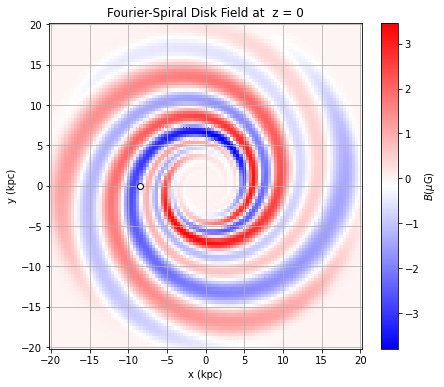

In [8]:
z = 0

# grid of x and y values
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_spiral_field(xx[i,j], yy[i,j], z)
        B2 = get_spiral_field2(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])
        if not np.array_equal(B, B2):
            print("Error")



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Fourier-Spiral Disk Field at  z = 0')
plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

## Spiral Spur disk field

Parameters for spur model

In [9]:
fDiskB1        = -4.2993328e+00 * microgauss
fDiskH         =  7.5019749e-01 * kpc
fDiskPhase1    =  1.5589875e+02 * degree
fDiskPitch     =  1.2074432e+01 * degree
fDiskW         =  1.2263120e-01 * kpc
fPoloidalB     =  9.9302987e-01 * microgauss
fPoloidalP     =  1.3982374e+00 * kpc
fPoloidalR     =  7.1973387e+00 * kpc
fPoloidalW     =  1.2262244e-01 * kpc
fPoloidalZ     =  4.4853270e+00 * kpc
fSpurCenter    =  1.5718686e+02 * degree
fSpurLength    =  3.1839577e+01 * degree
fSpurWidth     =  1.0318114e+01 * degree
fStriation     =  3.3022369e-01
fToroidalBN    =  2.9286724e+00 * microgauss
fToroidalBS    = -2.5979895e+00 * microgauss
fToroidalR     =  9.7536425e+00 * kpc
fToroidalW     =  1.4210055e+00 * kpc
fToroidalZ     =  6.0941229e+00 * kpc

fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

In [10]:
def get_spur_field(x, y, z):
    # reference approximately at solar radius
    r_ref = 8.2 * kpc

    # cylindrical coordinates
    r2 = np.power(x, 2) + np.power(y, 2)
    r = np.sqrt(r2)
    if r < np.finfo(float).tiny:
        return np.array([0, 0, 0])

    phi = np.arctan2(y, x)
    if phi < 0:
        phi += kTwoPi
    
    phi_ref = fDiskPhase1
    # ??
    i_best = -2
    best_dist = -1
    for i in range(-1, 2):
        pphi = phi - phi_ref + i * kTwoPi
        rr = r_ref * np.exp(pphi * fTanPitch)
        if best_dist < 0 or np.abs(r - rr) < best_dist:
            best_dist = np.abs(r - rr)
            i_best = i

    if i_best == 0:
        # Eq. 12
        phi0 = phi - np.log(r / r_ref) / fTanPitch

        # Eq. (16)
        delta_phi0 = delta_phi(phi_ref, phi0)
        # print(delta_phi0)
        # print(phi0-phi_ref)
        delta = delta_phi0 / fSpurWidth
        b = fDiskB1 * np.exp(-0.5 * delta**2)

        # Eq. (18)
        w_s = 5 * degree
        phi_c = fSpurCenter
        delta_phi_c = delta_phi(phi_c, phi)
        l_c = fSpurLength
        g_s = 1 - sigmoid(np.abs(delta_phi_c), l_c, w_s)

        # Eq. (13)
        hd = 1 - sigmoid(np.abs(z), fDiskH, fDiskW)

        # Eq. (17)
        b_s = r_ref / r * b * hd * g_s
        b_cyl = np.array([b_s * fSinPitch, b_s * fCosPitch, 0])
        
        cos_phi = x / r
        sin_phi = y / r
        return cyl_to_cart(b_cyl, cos_phi, sin_phi)
    else:
        return np.array([0, 0, 0])

### Make function for polar coordinates

In [11]:
def get_spur_field_cyl(rho, phi, z):
    # reference approximately at solar radius
    r_ref = 8.2 * kpc
    phi_ref = fDiskPhase1

    if rho < np.finfo(float).tiny:
        return np.array([0, 0, 0])


    if phi < 0:
        phi += kTwoPi

    
    # ??
    i_best = -2
    best_dist = -1
    for i in range(-1, 2):
        pphi = phi - phi_ref + i * kTwoPi
        rr = r_ref * np.exp(pphi * fTanPitch)
        if best_dist < 0 or np.abs(rho - rr) < best_dist:
            best_dist = np.abs(rho - rr)
            i_best = i

    if i_best == 0:
        # Eq. 12
        phi0 = phi - np.log(rho / r_ref) / fTanPitch

        # Eq. (16)
        delta_phi0 = delta_phi(phi_ref, phi0)
        delta = delta_phi0 / fSpurWidth
        b = fDiskB1 * np.exp(-0.5 * delta**2)

        # Eq. (18)
        w_s = 5 * degree
        phi_c = fSpurCenter
        delta_phi_c = delta_phi(phi_c, phi)
        l_c = fSpurLength
        g_s = 1 - sigmoid(np.abs(delta_phi_c), l_c, w_s)

        # Eq. (13)
        hd = 1 - sigmoid(np.abs(z), fDiskH, fDiskW)

        # Eq. (17)
        b_s = r_ref / rho * b * hd * g_s
        b_cyl = np.array([b_s * fSinPitch, b_s * fCosPitch, 0])
        
        return b_cyl
    else:
        return np.array([0, 0, 0])

In [12]:
def get_spur_field2(x, y, z):
    # cylindrical coordinates
    r2 = np.power(x, 2) + np.power(y, 2)
    r = np.sqrt(r2)

    phi = np.arctan2(y, x)
    
    b_cyl = get_spur_field_cyl(r, phi, z)
    cos_phi = x / r
    sin_phi = y / r
    
    return cyl_to_cart(b_cyl, cos_phi, sin_phi)

### Plotting

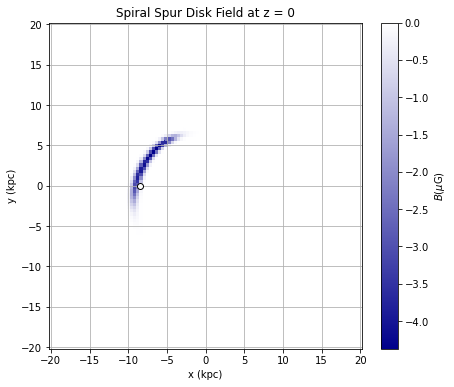

In [13]:
z = 0

# grid of x and y values
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_spur_field(xx[i,j], yy[i,j], z)
        B2 = get_spur_field(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])
        if not np.array_equal(B, B2):
            print("Error")


cmap0 = LinearSegmentedColormap.from_list('', ['darkblue', 'white'])
plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=cmap0, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Spiral Spur Disk Field at z = 0')
plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()